**Install dependencies**

In [ ]:
# !pip install -U beautifulsoup4 cloudscraper pandas pillow
# !pip install -U cjm_pil_utils cjm_parallel_utils

**Import dependencies**

In [ ]:
import random
from pathlib import Path
import json
import queue
from functools import partial

from PIL import Image
from bs4 import BeautifulSoup
import cloudscraper

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

In [ ]:
from cjm_pil_utils.core import get_img_files
from cjm_parallel_utils.core import parallel

In [ ]:
dataset_path = Path("/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/")
dataset_path

PosixPath('/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg')

In [ ]:
# Set the path for the images directory
img_dir = Path(dataset_path/"images/")

In [ ]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(img_dir)

# Print the number of images in the images directory
print(len(img_paths))

109971


In [ ]:
# Create a dictionary mapping image IDs to image paths
img_path_dict = {int(path.stem.split('-')[-1]) : path for path in img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_path_dict, orient='index').head()

,0
1061142,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-art-background-1061142.jpg
2586334,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-wtc-artist-concert-1460032.jpg
1061133,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/10-art-artistic-1061133.jpg
1339845,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/10-art-color-1339845.jpg


In [ ]:
img_ids = list(img_path_dict.keys())
len(img_ids)

109971

ID: 1522186
Size: (768, 1152)


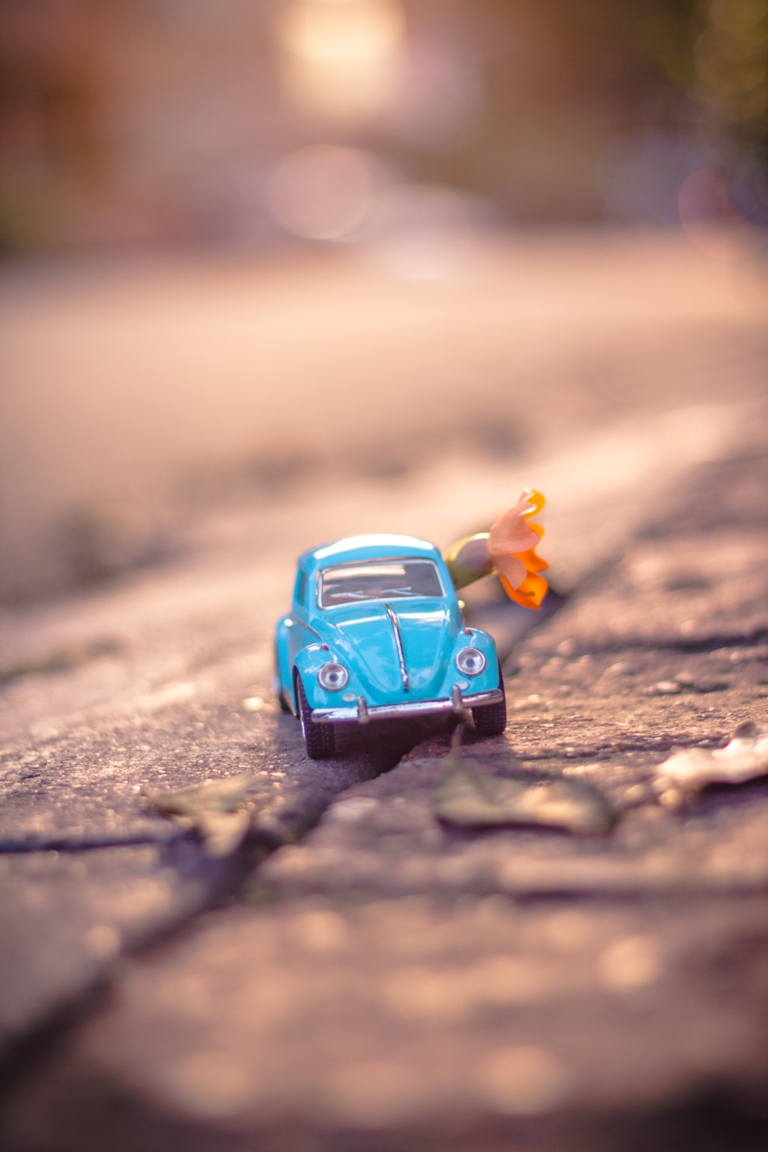

In [ ]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids)

img_id = 1522186

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = img_path_dict[img_id]
sample_img = Image.open(img_path)

print(f"Size: {sample_img.size}")

# Display the image
sample_img

In [ ]:
def get_tag_terms(data_dict):
    tags = data_dict['props']['pageProps']['medium']['attributes']['tags']
    tag_terms = [tag['search_term'] for tag in tags]
    return tag_terms

In [ ]:
def get_medium_attributes(data_dict):
    medium_attr_df = pd.DataFrame.from_dict(data_dict['props']['pageProps']['medium']['attributes'], orient='index')
    drop_list = ['description', 'width', 'height', 'slug', 'status', 'created_at', 'updated_at', 'publish_at', 'feed_at', 'license', 'published', 'starred', 'user', 'tags', 'image', 'alt', 'donate_url', 'collection_ids', 'liked']
    medium_attr_df = medium_attr_df.drop(drop_list).transpose()
    medium_attr_df['tags'] = ['']
    medium_attr_df.at[0, 'tags'] = get_tag_terms(data_dict)
    return medium_attr_df

In [ ]:
def get_medium_detail_attributes(data_dict):
    medium_detail_attr_df = pd.DataFrame.from_dict(data_dict['props']['pageProps']['mediumDetails']['attributes'], orient='index')
    drop_list = ['copyright', 'created_at', 'fingerprint', 'updated_at', 'photographer', 'photographed_at', 'size', 'photo_id']
    return medium_detail_attr_df.drop(drop_list).transpose()

In [ ]:
def get_attributes(img_id, attr_q, missing_q):
    url = f"https://www.pexels.com/photo/{img_id}"
    page_resp = scraper.get(url)
    html_soup = BeautifulSoup(page_resp.text, 'html.parser')
    try:
        next_data_dict = json.loads(html_soup.find('script', type='application/json').string)
        if next_data_dict is not None:
            if 'medium' not in next_data_dict['props']['pageProps']:
                missing_q.put(img_id)
                return
            if next_data_dict['props']['pageProps']['medium']['attributes']['title'] is None:
                missing_q.put(img_id)
                return
            medium_attr_df = get_medium_attributes(next_data_dict)
            medium_detail_attr_df = get_medium_detail_attributes(next_data_dict)
            attributes_df = pd.concat([medium_attr_df, medium_detail_attr_df], axis=1).set_index('id')
            attr_q.put(attributes_df)
    except:
        missing_q.put(img_id)

In [ ]:
scraper = cloudscraper.create_scraper()

In [ ]:
attr_q = queue.Queue()
missing_q = queue.Queue()

In [ ]:
get_attributes(img_id, attr_q, missing_q)

In [ ]:
attr_q.queue[0]

,title,aspect_ratio,main_color,colors,tags,adult,aperture,camera,focal_length,google_place_id,iso,latitude,longitude,manufacturer,medical,orientation,racy,shutter_speed,software,spoof,violence,location
id,,,,,,,,,,,,,,,,,,,,,,
1522186,Blue Volkswagen Beetle Coupe in Selective-focus Photography,0.666667,"[169, 133, 123]","[#000000, #87cefa, #bc8f8f, #ffdab9]","[automobile, blur, bokeh, car, close-up, flora, flower, focus, little, miniature, outdoors, pavement, road, small, still life, street, tiny, toy, toy car, vehicle, vintage]",very_unlikely,2.0,Canon EOS 60D,50.0,None,160,None,None,Canon,very_unlikely,0,very_unlikely,None,Adobe Photoshop Lightroom 5.3 (Macintosh),very_unlikely,very_unlikely,None


In [ ]:
attr_q = queue.Queue()
missing_q = queue.Queue()

In [ ]:
parallel(partial(get_attributes, attr_q=attr_q, missing_q=missing_q), arr=img_ids)

In [ ]:
len(attr_q.queue), len(missing_q.queue)

(387, 24)

In [ ]:
with open(Path(dataset_path/"missing_img_ids-new.txt"), "w") as write_file:
    for img_id in list(missing_q.queue):
        write_file.write(f"{img_id}\n")

In [ ]:
attributes_df = pd.concat(list(attr_q.queue))
attributes_df.head()

,title,aspect_ratio,main_color,colors,tags,adult,aperture,camera,focal_length,google_place_id,iso,latitude,longitude,manufacturer,medical,orientation,racy,shutter_speed,software,spoof,violence,location
id,,,,,,,,,,,,,,,,,,,,,,
101539,Brown Ink Pen,1.500214,"[129, 119, 114]","[#14181b, #4c5052, #86807e, #c1b1a8]","[business, calligraphy, composition, fountain pen, gold, hand lettering, handwritten, ink, letters, note, paper, pen, text, vintage, writing]",None,14.0,Canon EOS 70D,50.0,None,None,None,None,Canon,None,0,None,4/1,None,None,None,None
1061142,Bike Chain Number One,1.504,"[223, 117, 70]","[#f0ffff, #ff7f50]","[art, background, chain, chain link, color, copy space, creativity, design, digit, gear, illustration, mechanical, metal, mockup, number, object, one, one piece background, one piece wallpaper, orange background, shape, silver, steel, symbol]",very_unlikely,8.0,NIKON D3200,50.0,ChIJB3UJ2yYAzoURQeheJnYQBlQ,200,19.4326077,-99.133208,NIKON CORPORATION,very_unlikely,1,unlikely,,Adobe Photoshop CS6 (Windows),very_unlikely,very_unlikely,"Mexico City, CDMX, Mexico"
1061133,Bike Chain Forming 1 and 0,1.504,"[220, 117, 71]","[#000000, #696969, #a0522d, #a9a9a9, #f0f8ff, #ff7f50]","[10, abstract, art, artistic, background, bicycle, bike, chain, chrome, color, creativity, decoration, design, digit, education, element, font, gear, graphic, illustration, industrial, industry, linked, machine, mechanical, metal, metallic, number, object, pattern, reflection, set, shape, shine, shiny, silver, steel, style, symbol, ten, texture, type, vector]",very_unlikely,8.0,NIKON D3200,50.0,ChIJB3UJ2yYAzoURQeheJnYQBlQ,200,19.4326077,-99.133208,NIKON CORPORATION,very_unlikely,1,unlikely,,Adobe Photoshop CS6 (Windows),very_unlikely,very_unlikely,"Mexico City, CDMX, Mexico"
1339845,Number 10 Text,1.486746,"[245, 43, 64]","[#d2b48c, #dc143c, #f08080]","[10, art, color, conceptual, count, creativity, design, education, font, illustration, image, learn, numbers, red, sign, symbol, ten]",very_unlikely,5.6,Canon EOS 7D Mark II,70.0,None,1000,None,None,Canon,very_unlikely,0,possible,,Adobe Photoshop Lightroom Classic 7.3.1 (Windows),very_unlikely,very_unlikely,None
1779823,Snow-covered Mountain,1.5,"[54, 82, 88]","[#2f4f4f, #696969, #d2b48c]","[altitude, bird s eye view, clouds, cold, daylight, daytime, environment, freezing, frost, frosty, frozen, glacier, high, ice, icy, landscape, majestic, mountain range, mountains, nature, outdoors, scenic, sky, snow, snow capped, snow capped mountains, snowy, trees, view, weather, winter, winter landscape]",very_unlikely,8.0,NIKON D7500,62.0,None,160,None,None,NIKON CORPORATION,very_unlikely,0,very_unlikely,,Adobe Lightroom CC 2.1.1 (Windows),very_unlikely,very_unlikely,None


In [ ]:
attributes_df_json_path = Path(dataset_path/'attributes_df-new.json')
attributes_df_json_path

PosixPath('/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/attributes_df-new.json')

In [ ]:
attributes_df.to_json(attributes_df_json_path)